In [1]:
import tensorflow as tf

In [2]:
from package.process_data import *
from package.cluster_hundler import *
from package.model_hundler import *
from package.miscellaneous import *

In [3]:
def build_data_to_generator(df, filter_c_name, params):
    """Generate the data to fit cluster. The shape of output is (length, 3)

    @df: Dataframe accumulated and not normalized. Must have "z" column
    @filter_c_name: Filter column name. Usually as "filter_"
    @params: dict with x column name (odometer), y column name (tis) and so on.
        params['length']: length of each sample. The result is a list of samples with this length
    """

    X = []
    y = []

    df_f = df[df[params['x_col']] <= params['x_k']]
    df_f = df_f[df_f[params['y_col']] <= params['y_k']]

    df_g = df.sort_values([filter_c_name, params['x_col'], params['y_col']]).groupby(by=filter_c_name)
    df_f_g = df_f.sort_values([filter_c_name, params['x_col'], params['y_col']]).groupby(by=filter_c_name)

    z_max = 0

    x_c = int(params['x_k'] / params['x_step'])+1
    y_c = int(params['y_k'] / params['y_step'])+1

    x_t = int(params['x_max'] / params['x_step'])+1
    y_t = int(params['y_max'] / params['y_step'])+1

    for filter_ in df_g.indices:
        
        #X:
        f_df = df_f_g.get_group(filter_)
        X.append(np.array(f_df['z']).reshape((x_c, y_c)))

        #y:
        y.append(np.array(df_g.get_group(filter_)['z']).reshape((x_t, y_t)))

        z_max = max(z_max, f_df['z'].max())

    params['z_max']['general'] = z_max

    return np.array(X) / z_max, np.array(y) / z_max

In [4]:
##Generate the second architecture of the regressor model
params = dict({"x_col": "milge",
                "x_max": 70_000,
                "x_step": 2_000,
                "y_col": "tis_wsd",
                "key": "vin_cd",
                "y_max": 70,
                "y_step": 1,
                "y_k": 21, #number of tis to be considered as input to cluster
                "x_k": 30_000, #number of milge to be considered as input to cluster
                "z_max": dict(), #group1: value1, group2: value2, group3: value3
                "k": 4
                })

claims_df = pd.read_csv("./data/test_claims.tsv", sep='\t')
prod_df = pd.read_csv("./data/test_prod.tsv", sep='\t')

#TODO: The data used is already constructed and normalized.
#Build History Data
print("Built History Data")
history_data = build_data(  clm_list=claims_df, 
                            prod_list = prod_df, 
                            cols_group = ["veh_line_cd","eng_cd","mdl_yr","prt_num_causl_base_cd"], 
                            params=params)

print("Remove Outliers")
history_data = sel_dist_window(df = history_data, #TODO: add insert noise function
                                f_col = "filter_",
                                z_max = [2,40], #z_max: base and top
                                params = params,
                                max_filters=500)


X,y =  build_data_to_generator(df = history_data,
                                        filter_c_name = "filter_",
                                        params = params)

Built History Data
Remove Outliers


c:\Python\Python37\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [5]:
model = tf.keras.models.load_model("./models/base_conv.h5")
z_pred = model.predict(np.array([X[0]]))
z_2D = z_pred[0].reshape(36,71)

1/1 [==============================] - 4s 4s/step


In [7]:
w = 14
h = 9

X_input = create_X(params, 0)
df_arr = X_input[[params['x_col'], params['y_col']]].sort_values(by=[params['x_col'], params['y_col']]).values
x_p = int(params['x_max'] / params['x_step'])+1
y_p = int(params['y_max'] / params['y_step'])+1

x_2D = df_arr[:,0].reshape((x_p, y_p))
y_2D = df_arr[:,1].reshape((x_p, y_p))

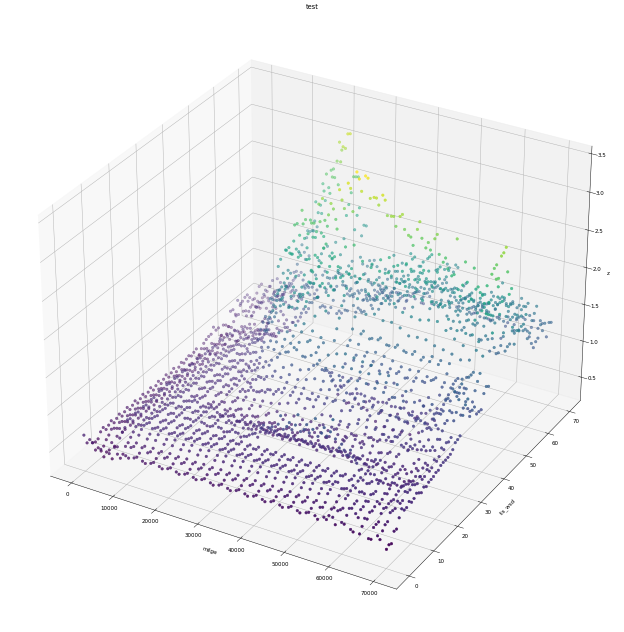

In [9]:
X_input.loc[:,'z'] = z_2D.reshape(x_p*y_p)
plot_df(data_df=X_input, x_col = params['x_col'], y_col=params['y_col'], z_col = "z", title='test',  w = 20, h = 20, dpi = 40)

In [ ]:

figure(figsize =(w, h))
ax = plt.axes(projection ='3d')

ax.plot_surface(df_arr[params['x_col']], y_2D, z_2D)
ax.set_title("title")
ax.set_ylabel(params['y_col'])
ax.set_xlabel(params['x_col'])
ax.set_zlabel("z")

plt.show()

In [ ]:
##To do:
"""
1. Add inference in unknow data
2. Add noise to fit data
3. Add postprocessing
"""